Running #:  0
Testing combination: LR=0.01, Units Layer1=64, Units Layer2=128, Dropout=0.5, Optimizer=Rprop
Epoch 1/20, Train Loss: 0.9795, Test Loss: 0.9486
Epoch 2/20, Train Loss: 0.9610, Test Loss: 0.9482
Epoch 3/20, Train Loss: 0.9614, Test Loss: 0.9471
Epoch 4/20, Train Loss: 0.9667, Test Loss: 0.9466
Epoch 5/20, Train Loss: 0.9606, Test Loss: 0.9465
Epoch 6/20, Train Loss: 0.9634, Test Loss: 0.9464
Epoch 7/20, Train Loss: 0.9614, Test Loss: 0.9463
Epoch 8/20, Train Loss: 0.9632, Test Loss: 0.9463
Epoch 9/20, Train Loss: 0.9672, Test Loss: 0.9462
Epoch 10/20, Train Loss: 0.9613, Test Loss: 0.9460
Epoch 11/20, Train Loss: 0.9554, Test Loss: 0.9459
Epoch 12/20, Train Loss: 0.9593, Test Loss: 0.9444
Epoch 13/20, Train Loss: 0.9575, Test Loss: 0.9437
Epoch 14/20, Train Loss: 0.9545, Test Loss: 0.9434
Epoch 15/20, Train Loss: 0.9532, Test Loss: 0.9433
Epoch 16/20, Train Loss: 0.9506, Test Loss: 0.9432
Epoch 17/20, Train Loss: 0.9591, Test Loss: 0.9431
Epoch 18/20, Train Loss: 0.9595, T

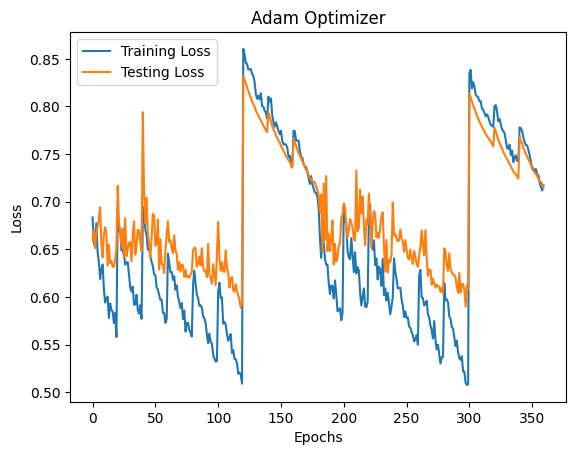

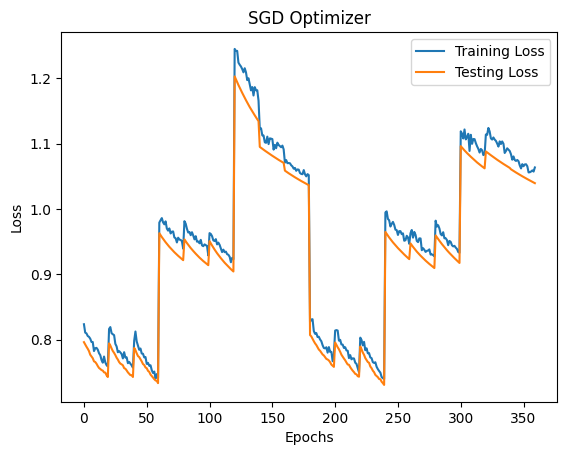

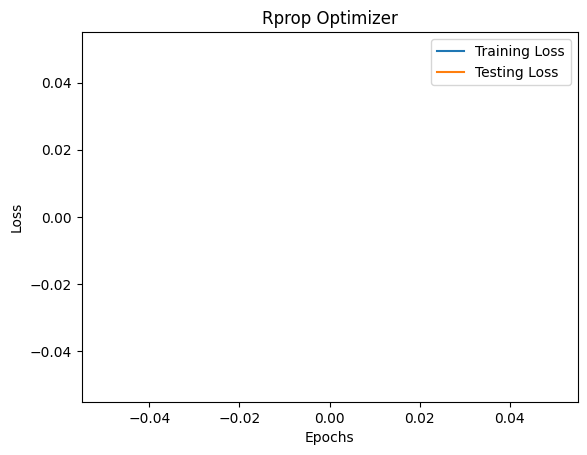

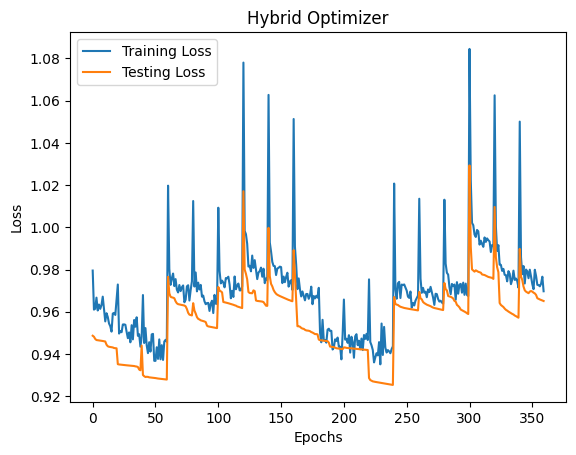

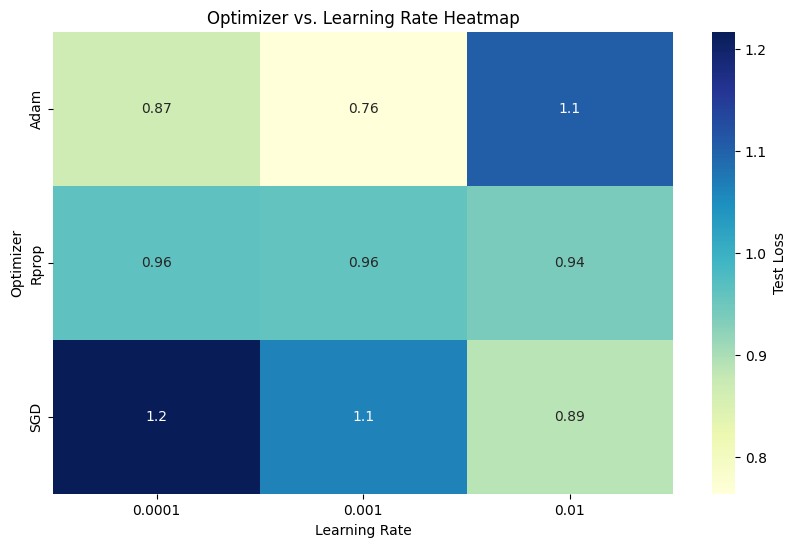

Test Accuracy: 0.4581


In [1]:

import itertools
import numpy as np
import tensorflow as tf
import time
from tensorflow import keras
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from constants import (
    TRAINX,
    TRAINY,
    TESTX,
    TESTY,
    SHAPEOFINPUT,
    UNITSLAYER1,
    UNITSLAYER2,
    RATEOFDROPOUT,
    OUTPUTUNITS, 
    HIDDENACTIVATION,
    OUTPUTACTIVATION,
    EPOCHSAMOUNT,
    BATCHSIZE,
    RATESOFLEARNING,
    UNITSLAYEROPTIONS1,
    UNITSLAYEROPTIONS2,
    DROPOUTRATES,
    OPTIMIZERS
)
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

starting_time = time.time()


np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
tf.random.set_seed(42)
tf.keras.layers.Dropout(rate=0.5)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False 

stochasticGradientDescentTrainLoss = []
stochasticGradientDescentTestLoss = []
adamTrainLoss = []
adamTestLoss = []
rmsTrainLoss = []
rmsTestLoss = []
rpropTrainLoss = []
rpropTestLoss = []
hybridTrainLoss = []
hybridTestLoss = []

paramsOfGridSearch = list(itertools.product(RATESOFLEARNING, UNITSLAYEROPTIONS1, UNITSLAYEROPTIONS2, DROPOUTRATES, OPTIMIZERS))
grid_search_results = {}
trainDataset = tf.data.Dataset.from_tensor_slices((TRAINX, TRAINY)).batch(BATCHSIZE).shuffle(buffer_size=1024, seed=42)
testingDataSet = tf.data.Dataset.from_tensor_slices((TESTX, TESTY)).batch(BATCHSIZE)

class AlmondNet(nn.Module):
    def __init__(self, input_size, units_layer1, units_layer2, output_size, dropout_rate):
        super(AlmondNet, self).__init__()
        self.fc1 = nn.Linear(input_size, units_layer1)
        self.fc2 = nn.Linear(units_layer1, units_layer2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(units_layer2, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.softmax(self.fc3(x), dim=1)
        return x
    

inputSize = SHAPEOFINPUT[0]

train_X = torch.tensor(TRAINX, dtype=torch.float32)
train_Y = torch.tensor(TRAINY, dtype=torch.float32)


def hybrid_train_step_pytorch(model, batch_x, batch_y, optimizers, criterion):
    for optimizer in optimizers.values():
        optimizer.zero_grad()

    output = model(batch_x)
    loss = criterion(output, torch.argmax(batch_y, dim=1))

    loss.backward()

    sgdGradients = [param.grad.clone() for param in model.parameters()]
    adamGradients = [param.grad.clone() for param in model.parameters()]
    rmspropGradients = [param.grad.clone() for param in model.parameters()]

    gradientAvg = [(grad_sgd + grad_adam + grad_rmsprop) / 3.0
                    for grad_sgd, grad_adam, grad_rmsprop in zip(
                        sgdGradients, adamGradients, rmspropGradients)]

    for param, avg_grad in zip(model.parameters(), gradientAvg):
        param.grad = avg_grad

    optimizers['Rprop'].step()

    return loss.item()


def train_pytorch_model_with_rprop(learning_rate, units_layer1, units_layer2, dropout_rate):
    model = AlmondNet(SHAPEOFINPUT[0], units_layer1, units_layer2, OUTPUTUNITS, dropout_rate)
    train_X = torch.tensor(TRAINX, dtype=torch.float32)
    train_Y = torch.tensor(TRAINY, dtype=torch.float32)
    test_X = torch.tensor(TESTX, dtype=torch.float32)
    test_Y = torch.tensor(TESTY, dtype=torch.float32)

    train_data = torch.utils.data.TensorDataset(train_X, train_Y)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCHSIZE, shuffle=True)

    model = AlmondNet(inputSize, units_layer1, units_layer2, OUTPUTUNITS, dropout_rate)
    criterion = nn.CrossEntropyLoss()

    optimizer_sgd = optim.SGD(model.parameters(), lr=learning_rate)
    optimizer_adam = optim.Adam(model.parameters(), lr=learning_rate)
    optimizer_rprop = optim.Rprop(model.parameters(), lr=learning_rate)

        
    for epoch in range(EPOCHSAMOUNT):
        model.train()
        total_loss = 0

        for batch_x, batch_y in train_loader:
            loss = hybrid_train_step_pytorch(
                model, 
                batch_x, 
                batch_y, 
                {'SGD': optimizer_sgd, 'Adam': optimizer_adam, 'Rprop': optimizer_rprop}, 
                criterion
            )
            total_loss += loss

        hybridTrainLoss.append(total_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            output = model(test_X)
            test_loss = criterion(output, torch.argmax(test_Y, dim=1))
            hybridTestLoss.append(test_loss.item())

        print(f"Epoch {epoch + 1}/{EPOCHSAMOUNT}, Train Loss: {hybridTrainLoss[-1]:.4f}, Test Loss: {hybridTestLoss[-1]:.4f}")
    
    return model

def evaluate_pytorch_model_with_accuracy(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        output = model(torch.tensor(TESTX, dtype=torch.float32))
        predicted_labels = torch.argmax(output, dim=1)
        true_labels = torch.argmax(torch.tensor(TESTY, dtype=torch.float32), dim=1)
        correct = (predicted_labels == true_labels).sum().item()
        total = true_labels.size(0)
        accuracy = correct / total
        test_loss = nn.CrossEntropyLoss()(output, true_labels)
        print(f"Test Loss: {test_loss.item()}, Test Accuracy: {accuracy:.4f}")
    return test_loss.item(), accuracy

def evaluate_model(testingDataSet):
    correctTotal = 0
    sampleTotal = 0
    for batchX, batchY in testingDataSet:
        predictions = model(batchX, training=False)
        predicted_labels = tf.argmax(predictions, axis=1)
        trueLabels = tf.argmax(batchY, axis=1)
        correctTotal += tf.reduce_sum(tf.cast(predicted_labels == trueLabels, dtype=tf.float32))
        sampleTotal += batchX.shape[0]
    
    accuracy = correctTotal / sampleTotal
    print(f"Test Accuracy: {accuracy:.4f}")
    
def plot_losses(training_losses, testing_losses, title):
    plt.plot(training_losses, label='Training Loss')
    plt.plot(testing_losses, label='Testing Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def calculate_accuracy(testingDataSet):
    correctTotals = 0
    sampleTotal = 0
    for batchX, batchY in testingDataSet:
        predictions = model(batchX, training=False)
        predicted_labels = tf.argmax(predictions, axis=1)
        trueLabels = tf.argmax(batchY, axis=1)
        correctTotals += tf.reduce_sum(tf.cast(predicted_labels == trueLabels, dtype=tf.float32))
        sampleTotal += batchX.shape[0]
    
    accuracy = correctTotals / sampleTotal
    return accuracy.numpy()

def hybrid_train_step(x, y, model, loss_func, optimizers):
    print("----hybrid_train_step----")
    with tf.GradientTape(persistent=True) as tape:
        predictions = model(x, training=True)
        loss = loss_func(y, predictions)
    
    sgdGradients = tape.gradient(loss, model.trainable_variables)
    adamGradients = tape.gradient(loss, model.trainable_variables)
    rmspropGradients = tape.gradient(loss, model.trainable_variables)
    
    gradientAvg = [(grad_sgd + grad_adam + grad_rmsprop) / 3.0
        for grad_sgd, grad_adam, grad_rmsprop in zip(sgdGradients, adamGradients, rmspropGradients)]
    
    optimizers['SGD'].apply_gradients(zip(gradientAvg, model.trainable_variables))
    optimizers['Adam'].apply_gradients(zip(gradientAvg, model.trainable_variables))
    
    return loss

def build_and_compile_model(learning_rate, units_layer1, units_layer2, dropout_rate, optimizer_name):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units_layer1, activation=HIDDENACTIVATION, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dense(units_layer2, activation=HIDDENACTIVATION, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(OUTPUTUNITS, activation=OUTPUTACTIVATION)
    ])
    
    if optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_X, train_Y, epochs=EPOCHSAMOUNT, batch_size=BATCHSIZE)
    
    return model

def train_model(model, trainDataset, testing_dataset, optimizer_name, hybrid=False):
    loss_func = tf.keras.losses.CategoricalCrossentropy()
    
    if hybrid:
        optimizers_dict = {
            'SGD': tf.keras.optimizers.SGD(learning_rate=0.01),
            'Adam': tf.keras.optimizers.Adam(learning_rate=0.001)
        }
    trainingLoss = []
    testingLoss = []
    
    for epoch in range(EPOCHSAMOUNT):
        total_train_loss = 0.0
        sample_total = 0
        
        for step, (batch_x, batch_y) in enumerate(trainDataset):
            if hybrid:
                loss = hybrid_train_step(batch_x, batch_y, model, loss_func, optimizers_dict)
            else:
                with tf.GradientTape() as tape:
                    predictions = model(batch_x, training=True)
                    loss = loss_func(batch_y, predictions)
                gradients = tape.gradient(loss, model.trainable_variables)
                model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            total_train_loss += loss.numpy() * batch_x.shape[0]
            sample_total += batch_x.shape[0]
        
        mean_train_loss = total_train_loss / sample_total
        trainingLoss.append(mean_train_loss)
        
        test_loss = evaluate_loss(model, testing_dataset, loss_func)
        testingLoss.append(test_loss)

    if optimizer_name == 'Adam':
        adamTrainLoss.extend(trainingLoss)
        adamTestLoss.extend(testingLoss)
    elif optimizer_name == 'SGD':
        stochasticGradientDescentTrainLoss.extend(trainingLoss)
        stochasticGradientDescentTestLoss.extend(testingLoss)
    elif hybrid:
        hybridTrainLoss.extend(trainingLoss)
        hybridTestLoss.extend(testingLoss)
    print(f"Epoch {epoch + 1}/{EPOCHSAMOUNT}, Train Loss: {mean_train_loss:.4f}")
        
    return model

def evaluate_loss(model, testing_dataset, loss_func):
    total_loss = 0.0
    total_samples = 0
    
    for batch_x, batch_y in testing_dataset:
        predictions = model(batch_x, training=False)
        loss = loss_func(batch_y, predictions)
        total_loss += loss.numpy() * batch_x.shape[0]
        total_samples += batch_x.shape[0]
    
    return total_loss / total_samples


num_runs = 2

results = {
    'Algorithm': [],
    'Run': [],
    'Learning Rate': [],
    'Units Layer1': [],
    'Units Layer2': [],
    'Dropout Rate': [],
    'Train Loss': [],
    'Test Loss': [],
    'Test Accuracy': [],
    'Training Time': []
}

for run in range(num_runs):
    print('Running #: ', run)
    for (learning_rate, units_layer1, units_layer2, dropout_rate, optimizer_name) in paramsOfGridSearch:
        print(f"Testing combination: LR={learning_rate}, Units Layer1={units_layer1}, Units Layer2={units_layer2}, Dropout={dropout_rate}, Optimizer={optimizer_name}")
        
        start_time = time.time()
        if optimizer_name != 'Hybrid' and optimizer_name != 'Rprop':
            model = build_and_compile_model(learning_rate, units_layer1, units_layer2, dropout_rate, optimizer_name)
            trained_model = train_model(model, trainDataset, testingDataSet, optimizer_name)
            test_loss, test_acc = trained_model.evaluate(testingDataSet)
        elif optimizer_name == 'Rprop':
            trained_model = train_pytorch_model_with_rprop(learning_rate, units_layer1, units_layer2, dropout_rate)
            test_loss, test_acc = evaluate_pytorch_model_with_accuracy(trained_model)
        else:
            model = build_and_compile_model(learning_rate, units_layer1, units_layer2, dropout_rate, optimizer_name)            
            trained_model = train_model(model, trainDataset, testingDataSet, optimizer_name, hybrid=True)
            test_loss, test_acc = trained_model.evaluate(testingDataSet)

        end_time = time.time()
        training_time = end_time - start_time
        
        
        grid_search_results[(learning_rate, units_layer1, units_layer2, dropout_rate, optimizer_name)] = test_acc
        results['Algorithm'].append(optimizer_name)
        results['Run'].append(run)
        results['Learning Rate'].append(learning_rate)
        results['Units Layer1'].append(units_layer1)
        results['Units Layer2'].append(units_layer2)
        results['Dropout Rate'].append(dropout_rate)
        results['Train Loss'].append(None)
        results['Test Loss'].append(test_loss)
        results['Test Accuracy'].append(test_acc)
        results['Training Time'].append(training_time)

results_df = pd.DataFrame(results)
best_hyperparams = max(grid_search_results, key=grid_search_results.get)
best_accuracy = grid_search_results[best_hyperparams]

print(f"Best Hyperparameter Combination: Learning Rate={best_hyperparams[0]}, Units Layer1={best_hyperparams[1]}, Units Layer2={best_hyperparams[2]}, Dropout Rate={best_hyperparams[3]}, Optimizer={best_hyperparams[4]}")
print(f"Best Accuracy: {best_accuracy * 100:.2f}%")

accuracyOfTest = calculate_accuracy(testingDataSet)
print(f"Test Accuracy: {accuracyOfTest * 100:.2f}%")

plot_losses(adamTrainLoss, adamTestLoss, "Adam Optimizer")
plot_losses(stochasticGradientDescentTrainLoss, stochasticGradientDescentTestLoss, "SGD Optimizer")
plot_losses(rpropTrainLoss, rpropTestLoss, "Rprop Optimizer")
plot_losses(hybridTrainLoss, hybridTestLoss, "Hybrid Optimizer")

heatmap_data = results_df.pivot_table(index='Algorithm', columns='Learning Rate', values='Test Loss')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Test Loss'})
plt.title('Optimizer vs. Learning Rate Heatmap')
plt.xlabel('Learning Rate')
plt.ylabel('Optimizer')
plt.show()
evaluate_model(testingDataSet)
